# Caso Practico

## Enunciado:

En la empresa “Seguros CDF” se comercializa sus productos a través de distintos canales. Estos productos son adquiridos de manera voluntaria por los clientes y pueden ser cancelados en cualquier momento. El equipo comercial ha detectado que muchas de las ventas se cancelan dentro de los primeros 4 meses y necesita definir una estrategia proactiva para retener a sus clientes. Es por ello que se está apoyando en el equipo de Data Analytics de Seguros CDF para que mediante un modelo predictivo pueda ayudar a definir la estrategia más adecuada.


## Planteamiento de la solucion:

Modelo de Clasifiacion binary (binary classification model)

`Target = 1` -> Se cancela el seguro dentro de los primeros 4 meses

`Target = 0` -> No se cancela el seguro dentro de los primeros 4 meses

### Modelos

El modelo entregara la probabilidad `p`, dadas las features de entrada, de que el target = 1 se suscite.

Dependiendo del valor de `p` se tomaran las medidas proactivas respectivas. Teniendo en cuenta que a mayor sea su valor, el modelo esta mas confidente de que se suscite la cancelacion del seguro.

---

> Santiago Madariaga Collado


In [267]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

# Para el modelo base
# import libraries to create a binary classification model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Para el modelo final
import lightgbm as lgb

# Exploratory Data Analysis


 + Descripcion de las variables numericas

 + 

In [284]:
# Import the dataset
# read a xlsx file using pandas 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html

dataset = pd.read_excel('Base_Cancelaciones_UseCase.xlsx')

# El numero del certificado representa un contrato, por lo que es un dato unico
print(f"Unique values: {len(dataset.NUM_CERTIFICADO.unique())} | total non-null values: {dataset.NUM_CERTIFICADO.dropna().count()}")

print(f"Clientes unicos:{len(dataset.COD_CLIENTE.unique())} \nClientes duplicados: {dataset.COD_CLIENTE.duplicated().sum()}"  )

dataset.head()

Unique values: 118952 | total non-null values: 120000
Clientes unicos:116188 
Clientes duplicados: 3812


,COD_CLIENTE,PRODUCTO,NUM_CERTIFICADO,FECHA_INICIO,FECHA_CANCELACION,FLAG_CANCELADO
0,30bcb9290daee609d26c5780839c0a48e5faf39f65e1f2...,1,c940427a73c497b10f1f223ddb416f7403293120821172...,2021-03-12,2021-03-18 00:00:00,1
1,bad01b3b590275f7b1729f2012b2eb05a820f1217544d7...,4,5d31273ad02e1f9626faed1ee3a9ac7dab01aef1d239bb...,2021-07-23,2021-10-07 00:00:00,1
2,e2350ee66445c6e35dcf05a42684e0625b479762e1cfc3...,1,c0663d4b54e3901f68d9b70d4e2f2b747831be2a23efc7...,2021-09-27,2022-02-01 00:00:00,1
3,8dae800d252d2fbb817ca498bb8cbdf4e77f46a02260e7...,1,1c23156ed8e7de34160f513305d84d30ef00a73e044629...,2022-05-09,-,0
4,9a0f0371a3754818a5dc983ab96bc799e25743821d4bdf...,1,2caa655347e3584e3c977f6ee2fd0834e43213272df493...,2021-09-13,2022-12-12 00:00:00,1


 + Se asume que **NUM_CERTICIADO** es la llave primaria de los datos. Es decir, no pueden haber certificados duplicados.

In [ ]:
dataset = dataset.drop_duplicates(subset=['NUM_CERTIFICADO'])

In [ ]:
# Procesado de la fecha
df_cancelados = dataset[dataset['FLAG_CANCELADO'] == 1].copy()

# Convertir la fecha a datetime
df_cancelados.FECHA_CANCELACION = pd.to_datetime(df_cancelados.FECHA_CANCELACION, format='%Y-%m-%d %H:%M:%S')

df_cancelados.describe()

,PRODUCTO,FLAG_CANCELADO
count,78472.000000,78472.0
mean,1.701448,1.0
std,1.454984,0.0
min,1.000000,1.0
25%,1.000000,1.0
50%,1.000000,1.0
75%,1.000000,1.0
max,10.000000,1.0


In [ ]:
df_cancelados.FECHA_INICIO.describe()

C:\Users\olapu\AppData\Local\Temp\ipykernel_3472\331559756.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_cancelados.FECHA_INICIO.describe()


count                   79073
unique                    612
top       2021-05-31 00:00:00
freq                      348
first     2021-01-02 00:00:00
last      2022-10-31 00:00:00
Name: FECHA_INICIO, dtype: object

In [ ]:
dataset.groupby('PRODUCTO').count()

<AxesSubplot:xlabel='PRODUCTO'>

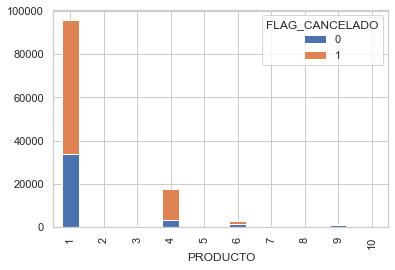

In [ ]:
# Fraccion de seguros cancelados, dependiendo del producto contratado
dataset.groupby(['PRODUCTO', 'FLAG_CANCELADO']).size().unstack().plot(kind='bar', stacked=True)

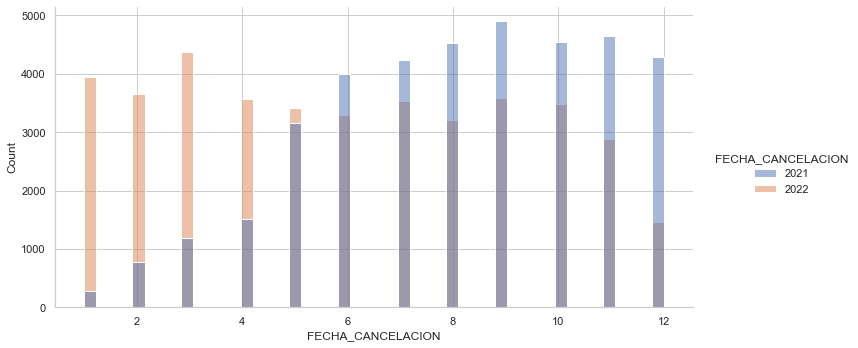

In [ ]:
sns.displot(data = df_cancelados, x = df_cancelados.FECHA_CANCELACION.dt.month, hue = df_cancelados.FECHA_CANCELACION.dt.year, palette=["C0", "C1"], height=5, aspect=2)

(0.0, 15.0)

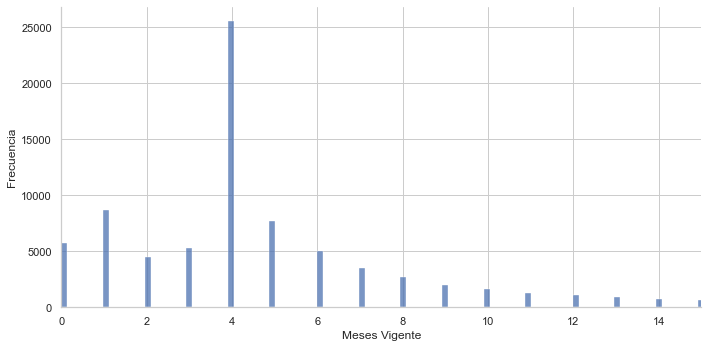

In [250]:
# Crear una columna con el numero de dias que ha estado vigente el seguro
df_cancelados['DIAS_VIGENTE'] = (df_cancelados.FECHA_CANCELACION - df_cancelados.FECHA_INICIO).dt.days

# Crear una columna con el numero de meses que ha estado vigente el seguro
df_cancelados['MESES_VIGENTE'] = round(df_cancelados['DIAS_VIGENTE'] / 30.5)

# sns.countplot(x = df_cancelados.MESES_VIGENTE, data = df_cancelados)
plota = sns.displot(x = df_cancelados.MESES_VIGENTE, data = df_cancelados, height=5, aspect=2)
plota.set(xlabel='Meses Vigente', ylabel='Frecuencia')
plota.axes[0,0].set_xlim(0, 15)

In [255]:
# Crear una columna con los dias feriados 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html

holidays = [datetime.datetime.fromisoformat(f"{y}-{x}") for x in ['01-01',  '07-28', '07-29', '12-25', '12-31'] for y in ['2021', '2022']]

holidays = list(set(np.array(list(map(lambda x: [x + datetime.timedelta(i) for i in range(-7, 3)], holidays))).flatten()))
print(f"N Feriados: {len(holidays)}")


# Crear columnas con los dias de contrato cancelado o creado, si se hicieron cerca de un feriado
dataset['INICIO_FERIADO'] = dataset.FECHA_INICIO.apply(lambda x: x in holidays)
print("mitad")
df_cancelados['CANCELADO_FERIADO'] = df_cancelados.FECHA_CANCELACION.apply(lambda x: x in holidays)

N Feriados: 65
mitad


## Procesado de la data

In [301]:

def process(df_: pd.DataFrame, holidays: list, input_cols = ['NUM_CERTIFICADO', 'COD_CLIENTE', 'FECHA_CANCELACION', 'FECHA_INICIO']):
    
    df = df_.copy()
    # Convertir la fecha a datetime
    df.FECHA_INICIO = pd.to_datetime(df.FECHA_INICIO, format='%Y-%m-%d %H:%M:%S')
    df.FECHA_CANCELACION = df.FECHA_CANCELACION.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S') if x != '-' else x) 

    df['INICIO_FERIADO'] = df.FECHA_INICIO.apply(lambda x: x in holidays).astype(int)
    dataset['SEMANA_INICIO'] = dataset.FECHA_INICIO.dt.isocalendar().week    

    print("Fechas convertidas al formato")
    # One hot encoding Producto
    df = pd.get_dummies(df, columns=['PRODUCTO'], prefix='PRODUCTO')

    # Normalizar semana de inicio
    minimo = df['SEMANA_INICIO'].min()
    maximo = df['SEMANA_INICIO'].max()
    df['SEMANA_INICIO'] = df['SEMANA_INICIO'].apply(lambda x: (x - minimo) / (maximo - minimo))
    
    # Convertir a la fecha en una funcion periodica
    
    df['INICIO_ENCODED'] = df.FECHA_INICIO.apply(lambda x: x.toordinal())
    minimo = df['INICIO_ENCODED'].min()
    maximo = df['INICIO_ENCODED'].max()
    df['INICIO_ENCODED'] = df['INICIO_ENCODED'].apply(lambda x: (x - minimo) / (maximo - minimo))
    df['INICIO_ENCODED'] = df['INICIO_ENCODED'].apply(lambda x: np.sin(x * 2 * np.pi))
    df.sort_values(by='FECHA_INICIO', inplace=True)
    print("Incio codificado")
    # Crear una columna con el numero de dias que ha estado vigente el seguro
    df['DIAS_VIGENTE'] = df.apply(lambda x: x.FECHA_CANCELACION - df.FECHA_INICIO if df.FLAG_CANCELADO == 1 else -1)

    # Crear una columna con el numero de meses que ha estado vigente el seguro
    df['MESES_VIGENTE'] = round(df['DIAS_VIGENTE'] / 30.5)
    print("labeling samples...")
    df['LABEL'] = df.MESES_VIGENTE.apply(lambda x: 1 if x <= 4 else 0)
    
    # Drop unnecesary cols para prevenir data leakage
    df.drop(columns=input_cols, inplace=True)
    
    return df

In [ ]:
# Crear una columna con el numero de la semana de la fecha de inicio
holidays = [datetime.datetime.fromisoformat(f"{y}-{x}") for x in ['01-01',  '07-28', '07-29', '12-25', '12-31'] for y in ['2021', '2022']]

holidays = list(set(np.array(list(map(lambda x: [x + datetime.timedelta(i) for i in range(-7, 3)], holidays))).flatten()))

pro_df = process(dataset, holidays=holidays)

In [ ]:
# split the dataset into train and test
train_df, test_df = train_test_split(pro_df, shuffle = False, test_size = 0.2)

# split the dataset into train and validation
train_df, val_df = train_test_split(train_df, shuffle = False, test_size = 0.2)

In [ ]:
# Fit a logistic regression model with train_df dataset and predict the probability of the test_df dataset
logreg = LogisticRegression(max_iter=1000)
logreg.fit(train_df.drop('LABEL', axis = 1), train_df.drop('LABEL', axis = 1).LABEL)
y_pred = logreg.predict_proba(test_df)[:, 1]

,COD_CLIENTE,NUM_CERTIFICADO,FECHA_INICIO,FECHA_CANCELACION,FLAG_CANCELADO,SEMANA_INICIO
PRODUCTO,,,,,,
1,95784,95784,95784,95784,95784,95784
2,220,220,220,220,220,220
3,527,527,527,527,527,527
4,17471,17471,17471,17471,17471,17471
5,46,46,46,46,46,46
6,3116,3116,3116,3116,3116,3116
7,673,673,673,673,673,673
8,81,81,81,81,81,81
9,1941,1941,1941,1941,1941,1941


In [ ]:
# Plot the ROC curvE
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_df.LABEL, y_pred)

In [ ]:
# GridSearch the best parameters for a LightGBM model
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'num_leaves': [31, 63, 127],

}

grid_search = GridSearchCV(estimator = lgbm, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(train_df.drop('LABEL', axis = 1), train_df.drop('LABEL', axis = 1).LABEL)

# Fit a LightGBM model with train_df dataset and predict the probability of the test_df dataset
lgbm = LGBMClassifier(learning_rate=0.05, n_estimators=300, num_leaves=31)
lgbm.fit(train_df.drop('LABEL', axis = 1), train_df.drop('LABEL', axis = 1).LABEL)
y_pred = lgbm.predict_proba(test_df)[:, 1]

# graficar ROC
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_df.LABEL, y_pred)
